In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
sys.path.insert(0,os.path.abspath(r"/home/mer49/Dropbox (Cambridge University)/OLeary/Code/"))
import neurotools
from neurotools.nlab import *

datadir = '/home/mer49/Dropbox (Cambridge University)/Shared/Prannoy/Code/20200317 MER GPs/'

In [3]:
from util          import *
from basics        import *
from simulate_data import *
from estimators    import *
from config        import *
from scipy.special import *
configure_pylab()   

import jax
import jax.numpy as np
import numpy.random as npr
import numpy as np0

from jax               import jit, grad, vmap
from jax.config        import config
from jax.scipy.special import logsumexp
from jax.numpy         import *
from jax               import jacfwd, jacrev
from jax               import lax
from jax.numpy.fft     import *
from jax.numpy.linalg  import *

from scipy.linalg.lapack import dtrtri

def ltinv(ch):
    q,info = scipy.linalg.lapack.dtrtri(ch,lower=True)
    if info!=0: raise ValueError('lapack.dtrtri: '+(
            'argument %d invalid'%-info if info<0 
            else 'diagonal element %d is 0'%info))
    return q
def slog(x):
    return log(maximum(1e-10,x))
def sexp(x):
    return exp(clip(x,-10,10))
def tdivl(A,B):
    return jax.scipy.linalg.solve_triangular(A,B,lower=True)
def tdivu(A,B):
    return jax.scipy.linalg.solve_triangular(A,B,lower=False)
def chol(x):
    return jax.scipy.linalg.cholesky(x,lower=True)
def lnd(A):
    return jax.numpy.linalg.slogdet(A)[1]
def reverse(A):
    return roll(roll(A[::-1,:],1,axis=0)[:,::-1],1,axis=1)
def lndpsd(Σ):
    return 2*sum(slog(diag(chol(Σ))))
def RI(x):
    return real(x)+imag(x)

In [4]:
# These are faster
from numpy.fft import *
import pyfftw
from pyfftw.interfaces.numpy_fft import *

In [5]:
tol    = 1e-4      # Newton convergence tolerance
mintol = 1e-5      # Minimum residual tolerance

L      = 64        # Grid size
T      = L*L       # Total number of basis functions 
P      = L/5       # Grid spacing
fgσ    = P/pi      # Foreground blur
bgσ    = fgσ*5     # Background blur
α      = 0.5       # Grid "sharpness"
μ      = 1500/L**2 # Mean firing rate (spikes per sample)

mask,λ0,λ0_bg,N,K = simulate_data(L,P,α,μ)

# Data

In [6]:
resolution = 5
# Settings for loop
pad = 0.6 # Pad to avoid wrap-around from circular convolution; 0.5=no padding
Fs  = 50.0 # Sample rate in Hz

# 2D grid coordinates as complex numbers
c = arange(L)-L//2
coords = 1j*c[:,None]+c[None,:]
bins = linspace(0,1,L+1)

# Resolution for the camera used to record R1 is 350px/m;
# resolution for other rats (R11 and R18) was 338px/m
px_p_meter = 338
#dataset = 'R18_20200131_1to2_EC_good.mat'
#dataset = 'R11_20190607_1to2_EC_good.mat'
px_p_meter = 350
dataset = 'R1_20190823_2to1_EC_good.mat'
datasetname = dataset.split('_')[0]

dataset_ID = re.match('(R\d+)_(\d+)',dataset).group(0)

# Use low-pass filtered velocity angle as heading 
# Positive dx is eastwards
# Negative dx is westwards
# Positive dy is .. northwards?
# Negative dy is .. southwards?
# Angle is computed as if a complex number
# So North is +90, West is ±180, South is -90, and East is 0
# sin(θ) is therefore the vertical direction
# with sin(θ)=1 being northwards
# Likewise cos(θ) is the horizontal direction
# with cos(θ)=1 being eastwards
# North: positive sin(θ)
# South: negative sin(θ)
# East : positive cos(θ)
# West : negative cos(θ)
# φ=0    is West
# φ=1/2π is South
# φ=π    is East
# φ=3/2π is North
φW = 0
φS = pi/2
φE = pi
φN = 3*pi/2

φs = linspace(0,2*pi,90+1)[:-1]
φiW = argmin(abs(φs-φW))
φiS = argmin(abs(φs-φS))
φiE = argmin(abs(φs-φE))
φiN = argmin(abs(φs-φN))
Fl = 0.25 # Low-frequency cutoff

In [7]:
# Load all datasets
data = loadmat(datadir+dataset,squeeze_me=True)
xy50 = data['xy50'] # Position
sp50 = data['sp50'] # Spikes
hd50 = data['hd50'] # Head angle
ndatasets  = len(xy50)

In [8]:

DODATASETS = range(ndatasets)

# Rescale location data from all datasets using same transformation
allxy50 = np0.concatenate(xy50)
x,y = allxy50.T
minx,maxx,miny,maxy = np.min(x),np.max(x),np.min(y),np.max(y)
delta = np0.max([maxx-minx,maxy-miny])
scale = (1-1e-6)/(delta*pad*2)
x     = (x-(maxx+minx)/2+delta*pad)*scale
y     = (y-(maxy+miny)/2+delta*pad)*scale

# Record grid scale
bins_p_meter = scale*L*px_p_meter
cm_p_bin     = 100/bins_p_meter
print('cm per bin',cm_p_bin)

# Quick hack patching load dataset to use common alignment for all cells
def load_dataset(fn,dataindex,pad):
    # Get all datasets
    data = loadmat(fn,squeeze_me=True)
    xy50 = data['xy50'] # Position
    sp50 = data['sp50'] # Spikes
    hd50 = data['hd50'] # Head angle
    # Get specified dataset
    x,y  = xy50[dataindex].T
    s    = sp50[dataindex]
    x    = (x-(maxx+minx)/2+delta*pad)*scale
    y    = (y-(maxy+miny)/2+delta*pad)*scale
    return s,x,y,scale

cm per bin 6.336424706262877


In [9]:
def bin_spikes(x,y,s,bins,w=None):
    # Bin spike counts
    N    = histogram2d(y,x,(bins,bins),density=0,weights=w)[0]
    ws   = s if w is None else array(s)*array(w)
    K    = histogram2d(y,x,(bins,bins),density=0,weights=ws)[0]
    return N,K

In [10]:
# Collect EW/NS field pairs from all cells 
all_EW = []
all_NS = []
all_all_maps = []

DOPLOTS = True
idata,dataindex = [*enumerate(DODATASETS)][0]

# Get specific dataset
s,x,y,scale = load_dataset(datadir+dataset,dataindex,pad)

# Grab spikes
st    = find(s>0)
xs,ys = x[st],y[st]
sk    = s[st]
N,K   = bin_spikes(x,y,s,bins)
y1    = nan_to_num(K/N)
mask  = blur(N>0,3)>0.1

In [11]:
# Calibrate grid scale
λhat   = kdeλ(N,K,L/75)
#λhat   = nan_to_num(K/N)
u = outer(hanning(L),hanning(L))
acorr2 = fft_acorr(λhat*u,mask) # Get 2D autocorrelation
acorrR = radial_average(acorr2) # Get radial autocorrelation
res    = 5                      # Subsampling resolution
P,acup = acorr_peak(acorrR,res) # Distance to first peak in bins    

print('P=',P)
fgσ  = P/pi
bgσ  = fgσ*2.5
λhat = kdeλ(N,K,fgσ)
λbg  = kdeλ(N,K,bgσ)

P= 3.0


In [12]:
# Calibrate kernel
# Make symmetric kernel from autocorrelation of ideal grid
acgrd = fft_acorr(ideal_hex_grid(L,P),mask)
kernR = radial_kernel(radial_average(acgrd))
# Restrict kernel to local neighborhood and normalize
window   = abs(coords)<P*sqrt(2)
#kern0 = blurkernel(L,P/pi*2,normalize=False)
#kern0 = outer(kern0,kern0)
kern0    = blur(kernR*fftshift(window),P/pi)
kern0    = kern0/np.max(kern0)
# Estimate zero-lag variance and scale kernel
acorrR1 = radial_acorr(nan_to_num(K/N),mask)
acorrR2 = np0.copy(acorrR1)
v0      = zerolag(acorrR1)
#kern    = kern0*v0
acorrR2[L//2] = v0

In [13]:

# Precompute variables; Passed as globals to jac/hess
n    = N.ravel()
y    = nan_to_num(K/N)
λhat = kdeλ(N,K,fgσ) # Foreground rate
λbg  = kdeλ(N,K,bgσ) # Background rate
lλh  = slog(λhat)    # Log rate
lλb  = slog(λbg)     # Log background

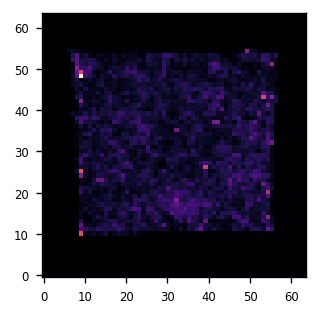

In [14]:
imshow(mask*(n.reshape(L,L)))

In [15]:
# Fourier convolution
def cv(K,v):
    return real(ifft2(fft2(v.reshape(L,L),norm='ortho')*K,norm='ortho')).ravel()
def cm(K,M):
    return real(ifft2(K[:,:,None]*fft2(M.reshape(L,L,M.shape[-1]),axes=(0,1)),axes=(0,1))).reshape(T,M.shape[-1])

In [16]:
# Prepare data
lλb  = slog(kdeλ(N,K,bgσ))     # Log background (initial estimate)
lλf  = slog(kdeλ(N,K,fgσ))-lλb # Log foreground (initial estimate)
n    = N.ravel()               # Number of visits per bin
y    = nan_to_num(K/N).ravel() # Lumped pseudo-observerations
lλb  = lλb.ravel()             # Background offsets
σ0   = zerolag(radial_acorr(lλf,mask))

def showfig():
    figure(figsize=(6,2))
    subplot(121)
    imshow(exp(μ+μ0+sum(FA(Q)**2,1)/2).reshape(L,L))
    axis('off')
    colorbar()
    subplot(122)
    FQ = FA(Q.reshape(R,R))
    imshow(sum(FQ**2,1).reshape(L,L))
    axis('off')
    colorbar()
    show()
    
def make_kernel_ft(L,P,σ0,dc=1e1,k=5):
    coords   = zgrid(L)
    window   = hanning(L)
    window   = fftshift(outer(window,window))
    kern     = j0(fftshift(abs(coords*2*pi/P)))*window
    clip     = fftshift(abs(coords)<P*jn_zeros(0,k)[-1]/(2*pi))
    kern     = kern*clip
    kern     = blur(kern,P/pi)
    kern     = repair_small_eigenvalues(kern*σ0/np.max(kern),1e-5)
    Kf       = np0.array(real(fft2(kern)))
    Kf[0,0] += dc
    return Kf

In [62]:
rP   = sqrt(2)
rβ   = 20
P_lo = P/rP
P_hi = P*rP
β_lo = 1/rβ
β_hi = 1*rβ
NP   = 11
Nβ   = 11
Ps   = exp(linspace(log(P_lo),log(P_hi),NP))
βs   = exp(linspace(log(β_lo),log(β_hi),Nβ))[::-1]

# Pick a subset of frequency components that can support all kernels
keep2d = zeros((L,L),dtype='bool',)
for ip,p in enumerate(Ps):
    Kf  = make_kernel_ft(L,p,σ0)
    thr1 = np.max(array(sorted(abs(Kf).ravel()))[:-1])*0.25
    thr2 = percentile(abs(Kf).ravel(),100-200/len(Kf.ravel())*100)
    thr  = np.min(array([thr2,thr1]))
    #thr=thr1
    keep2d |= (abs(Kf))>thr
keep  = where(keep2d.ravel())[0]
R     = len(keep)
Rlt   = (R*(R+1))//2
down  = eye(T)[keep]
hperm = int32(down@reverse((down.T@(arange(R))).reshape(L,L)).ravel())
print('Keeping R=%d out of %d components'%(R,T))
'''  
def trl(M,k=0): 
    if len(M.shape)==2: return M[np.tril_indices(M.shape[0],k=k)]
    if len(M.shape)==1: 
        N = int((np.sqrt(1+8*M.shape[0])-1)/2)
        return np.zeros((N,N)).at[np.tril_indices(N)].set(M)
    raise ValueError("Must be 2D matrix or 1D vector")
'''
# "diag" for lower-triangular matrices
trlr,trlc = tril_indices(R)
trlidxs = trlc + trlr*R
def trl(M): 
    if len(M.shape)==2: 
        return M.ravel()[trlidxs]
    if len(M.shape)==1: 
        Z = np0.zeros((R,R))
        Z[trlr,trlc]=M
        return Z
    raise ValueError("Must be 2D matrix or 1D vector")

@jit
def hcv(kh,xh):
    kh/= 2
    kr,xr = kh[hperm],xh[hperm]
    return (kh+kr)*xh+(kh-kr)*xr
@jit
def hcm(kh,xh):
    kh/= 2
    kr,xr = kh[hperm],xh[hperm]
    return (kh+kr)[:,None]*xh+(kh-kr)[:,None]*xr
@jit
def Ftv(v):
    return fhtv(v)[keep]
@jit
def Fv(v):
    return fhtv(zeros(T).at[keep].set(v))
@jit
def fhtv(v):
    return RI(fft2(v.reshape(L,L),norm='ortho').ravel())
def fhtA(x): # The main bottleneck; Most time taken by fft2
    return RI(fft2(x.reshape(R,L,L),norm='ortho').reshape(R,T))
def FtA(A):
    return fhtA(A.T).T[keep,:]
def FA(A):
    return fhtA(zeros((T,A.shape[-1])).at[keep,:].set(A).T).T
def dv(Q):
    return sum(FA(tril(Q))**2,1)

Keeping R=3411 out of 4096 components


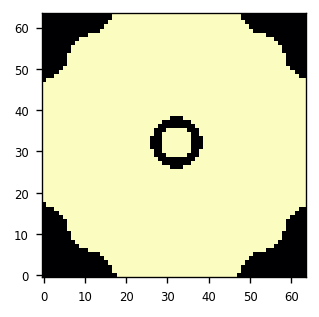

In [63]:
imshow(fftshift(keep2d))

# Hill-climbing search

This could be cleaner, but it is what it is

In [64]:
from functools import lru_cache as cache
@cache
def prepare_kernel(p):
    Kf = make_kernel_ft(L,p,σ0)
    Λf = 1.0/Kf
    K0 = real(ifft2(Kf))
    Kh = RI(Kf).ravel()[keep]
    Λh = RI(Λf).ravel()[keep]
    sK = sum(log(Kf[keep2d]))
    nK = sum(keep2d)
    return K0,Kf,Λf,Kh,Λh,sK,nK

def HvQ0_helper(M,β,nλ,FQ,Pt,Λh):
    FM  = FA(M)
    r   = nλ * sum(FQ*FM,1)
    return FtA(nλ[:,None]*FM+r[:,None]*FQ) + β*hcm(Λh,M) + Pt@M.T@Pt

def infer(μ,Q,β,p,maxiter=100):
    K0,Kf,Λf,Kh,Λh,sK,nK = prepare_kernel(p)
    def pMμ(u): return cv(Kf/β,u).ravel()
    Mμ = op(T,pMμ)
    def pMQ(M): return trl(hcm(Kh/β,trl(M)))
    MQ = op(Rlt,pMQ)
    for i in range(maxiter):
        # Precompute shared intermediate expressions
        Q  = tril(Q)
        FQ = FA(Q)
        Pt = ltinv(Q).T
        vc = sum(FQ**2,1)/2
        nλ = n*exp(μ+vc+μ0)
        # Gradient and hessian for μ
        J  = nλ - n*y + cv(β*Λf,μ)
        def hcvμ(u): return (nλ*u + cv(β*Λf,u)).ravel()
        Hv = op(T,hcvμ)
        # Solve Newton update for μ
        Δ  = minres(Hv,J,M=Mμ,tol=mintol)[0]
        μ -= Δ
        εμ = max(abs(Δ))
        # Recompute firing rate for update μ;
        nλ = n*exp(μ+μ0+vc)
        # Gradient and Hessian for Q
        J  = trl(hcm(β*Λh,Q) + FtA(nλ[:,None]*FQ) - Pt)
        def hcvM(M): return trl(HvQ0_helper(trl(M),β,nλ,FQ,Pt,Λh)) 
        Hv = op(Rlt,hcvM)
        # Solve Newton update for Q
        Δ  = trl(minres(Hv,J,M=MQ,tol=mintol)[0])
        Q -= Δ
        εQ = max(abs(Δ))
        # Return if converged
        if εμ<tol and εQ<tol: break
        print('i',i,'εμ',εμ,'εQ',εQ)
    return μ,Q,i

def loss(μ,Q,β,p):
    K0,Kf,Λf,Kh,Λh,sK,nK = prepare_kernel(p)
    Q  = tril(Q)
    FQ = FA(Q)
    λ  = exp(μ+μ0+sum(FQ**2,1)/2)
    return  n@(λ-y*μ) + μ.T@cv(β*Λf,μ)/2 + (sK-nK*log(β))/2 - sum(slog(diag(Q))) +  β*sum(FQ*cm(Λf,FQ))/2

def infer_and_get_loss(μ,Q,β,p):
    μ,Q,_ = infer(μ,Q,β,p)
    return μ,Q,loss(μ,Q,β,p)

μ  = lλf.ravel()
μ0 = lλb.ravel()
Q  = eye(R)

ip = NP//2
iβ = Nβ//2
p  = Ps[ip]
β  = βs[iβ]

μ,Q,l = infer_and_get_loss(μ,Q,β,float(p))
print('\tβ[%d] ='%iβ,β,'\tloss = ',l)
μref,Qref = μ,Q
results = np0.empty((NP,Nβ),dtype='object')
    
def current_best():
    global results
    losses  = array([inf if r is None else r[2] for r in results.ravel()])
    bestidx = argmin(losses)
    bestP,bestβ = unravel_index(bestidx,results.shape)
    return bestP, bestβ, losses[bestidx]    
    
from IPython.display import clear_output
    
def search(ip,iβ):
    global results
    print('P[%d]=%0.2f β[%d]=%0.2f'%(ip,Ps[ip],iβ,βs[iβ]))
    if iβ<0 or ip<0 or iβ>=Nβ or ip>=NP: return None
    if results[ip,iβ]: return results[ip,iβ]
    # Extrapolate when possible
    if iβ+2<Nβ and results[ip,iβ+1] and results[ip,iβ+2]:
        (μ1,Q1),(μ2,Q2) = results[ip,iβ+1][:2], results[ip,iβ+2][:2]
        μ = μ1 + μ1 - μ2
        Q = Q1 + Q1 - Q2
    elif iβ>=2 and results[ip,iβ-1] and results[ip,iβ-2]:
        (μ1,Q1),(μ2,Q2) = results[ip,iβ-1][:2], results[ip,iβ-2][:2]
        μ = μ1 + μ1 - μ2
        Q = Q1 + Q1 - Q2
    elif iβ+1<Nβ and results[ip,iβ+1]: μ,Q = results[ip,iβ+1][:2]
    elif iβ>=1   and results[ip,iβ-1]: μ,Q = results[ip,iβ-1][:2]
    elif ip+1<NP and results[ip+1,iβ]: μ,Q = results[ip+1,iβ][:2]
    elif ip>=1   and results[ip-1,iβ]: μ,Q = results[ip-1,iβ][:2]
    else: μ,Q = μref,Qref
    β = βs[iβ]
    μ,Q,l = infer_and_get_loss(μ,Q,β,float(p))
    results[ip,iβ] = (μ,Q,l)
    print('P[%d]=%0.2f β[%d]=%0.2f loss=%f'%(ip,Ps[ip],iβ,βs[iβ],l))
    clear_output(wait=True)
    figure()
    imshow(array([r[2] if not r is None else nan for r in results.ravel()]).reshape(NP,Nβ))
    show()
    search_order = [(0,1),(0,-1),(1,0),(-1,0)]#,(1,1),(1,-1),(-1,1),(-1,-1)]
    for Δp,Δβ in search_order:
        if current_best()[:2]!=(ip,iβ): break
        search(ip+Δp,iβ+Δβ)
    return results[ip,iβ]

#search(NP//2,Nβ//2)

i 0 εμ 3.1143997 εQ 0.99986655
i 1 εμ 0.47559524 εQ 0.34016287
i 2 εμ 0.07395828 εQ 0.048991125
i 3 εμ 0.0061569936 εQ 0.009189025
i 4 εμ 0.00013401346 εQ 0.006640702
i 5 εμ 3.672922e-06 εQ 0.0017302135
i 6 εμ 3.4576644e-06 εQ 0.0015677181
i 7 εμ 3.2944313e-06 εQ 0.00053467957
	β[5] = 1.0 	loss =  32860.605


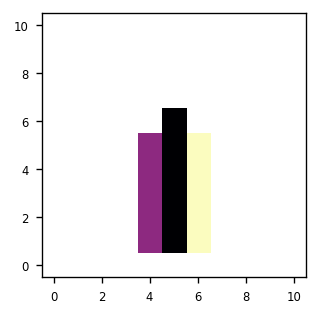

(DeviceArray([-0.122566044, -0.12200343 , -0.09960837 , ..., -0.12523994 ,
              -0.2099863  , -0.26315933 ], dtype=float32),
 DeviceArray([[ 1.1177453e+00,  0.0000000e+00,  0.0000000e+00, ...,
                0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
              [ 3.4184119e-01,  8.8397837e-01,  0.0000000e+00, ...,
                0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
              [ 2.4608889e-01,  1.9193040e-01,  6.9496846e-01, ...,
                0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
              ...,
              [-1.0333128e-02, -2.3263598e-04, -3.0607586e-03, ...,
                3.2852614e-01,  0.0000000e+00,  0.0000000e+00],
              [ 3.0061565e-03, -8.7119369e-03,  3.2907516e-05, ...,
                1.4248085e-01,  3.6846462e-01,  0.0000000e+00],
              [-1.3647386e-03, -7.9225487e-04, -1.1651479e-02, ...,
                1.1470052e-01,  1.2773792e-01,  3.4882534e-01]],            dtype=float32),
 DeviceArray(32860.605, dty

In [65]:
search(NP//2,Nβ//2)

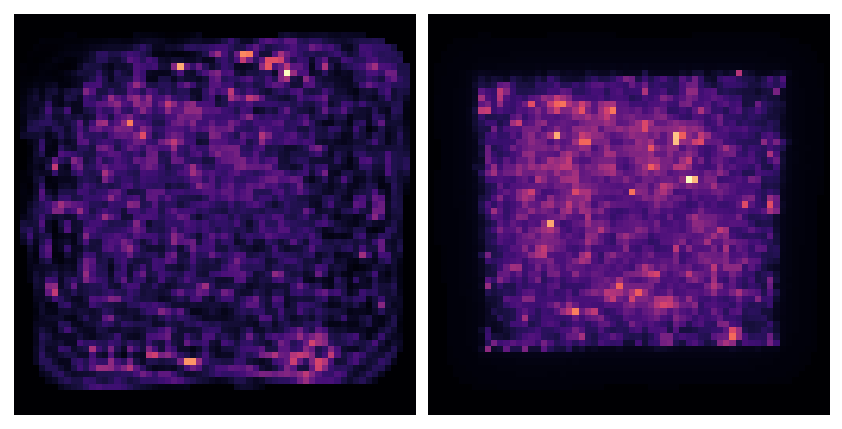

In [66]:
bestP, bestβ = current_best()[:2]
μ,Q,l = results[bestP,bestβ]
figure(figsize=(6,4))
subplot(121)
v = dv(Q)
imshow(mask * exp(μ+μ0+v/2).reshape(L,L))
axis('off')
subplot(122)
imshow(mask*1/v.reshape(L,L))
axis('off')
tight_layout()
savefig('test3')

In [90]:
βs[bestβ]

DeviceArray(0.18478498, dtype=float32)

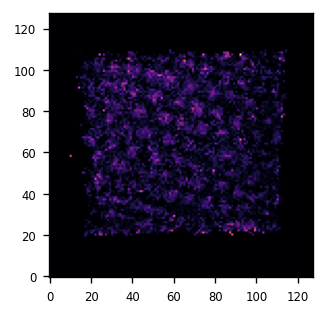

In [89]:
imshow(y.reshape(L,L))

# Stop! 

In [ ]:
infer(μ,Q,β,p,maxiter=100)